# Inhibitory Neuron Analysis

Create manifest to keep track of data

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cmath

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

In [5]:
# import functions from drifting_gratings file

from ipynb.fs.defs.drifting_gratings import dg_for_cell
from ipynb.fs.defs.drifting_gratings import plot_dg

In [6]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)

all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


In [7]:
# Download experiment containers for Sst and Vip experiments
Sst_ecs = boc.get_experiment_containers(cre_lines=['Sst-IRES-Cre'])
print("Sst experiments: %d\n" % len(Sst_ecs))

print("Example experiment container record:")
pprint.pprint(Sst_ecs[0])
print("\n")


Vip_ecs = boc.get_experiment_containers(cre_lines=['Vip-IRES-Cre'])
print("Vip experiments: %d\n" % len(Vip_ecs))

print("Example experiment container record:")
pprint.pprint(Vip_ecs[0])



Sst experiments: 64

Example experiment container record:
{'cre_line': 'Sst-IRES-Cre',
 'donor_name': '306500',
 'failed': False,
 'id': 660492886,
 'imaging_depth': 275,
 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'specimen_name': 'Sst-IRES-Cre;Ai148(CAM)-306500',
 'tags': [],
 'targeted_structure': 'VISal'}


Vip experiments: 76

Example experiment container record:
{'cre_line': 'Vip-IRES-Cre',
 'donor_name': '336246',
 'failed': False,
 'id': 617388115,
 'imaging_depth': 175,
 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'specimen_name': 'Vip-IRES-Cre;Ai148-336246',
 'tags': [],
 'targeted_structure': 'VISpm'}


In [8]:
# create_histogram(targeted_struct): creates histogram of OSI of all cells in desired cortical layer
# 
#
#
#
# targeted_struct: string argument identifying desired cortical layer. Options are
# 'VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'. Higher order visual cortices (VISam, VISpm, VISrl) show
# decreased activity with increased running speed
# print_OSIs: when set to true, will print the OSIs for each cell
# print_other_vals: when set to true, will print the Rmax, pref TF, pref ORI, Rorth, and gOSI
# filter_vals: when set to true, creates the histogram and excludes OSIs below 0 or above 2
#
# Warning: will require downloading nwb files for many cells. Will take a while 
def histogram_for_exp(exp_cont, print_OSIs, print_other_vals, filter_vals) :
    
    # Download experiment containers for experiments of target structure
    exp_containers = exp_cont
    print("all Sst experiment containers: %d" % (len(exp_containers)))
    
    # Download cells for a set of experiments and convert to DataFrame
    cells = boc.get_cell_specimens() # this code may be moved outside of the function?
    cells = pd.DataFrame.from_records(cells)
    print("total cells: %d" % len(cells))

    # find direction selective cells in VISp
    exp_container_ids = [ ec['id'] for ec in exp_containers ]
    structure_cells = cells[cells['experiment_container_id'].isin(exp_container_ids)]
    print("cells: %d" % len(structure_cells))

    # significant response to drifting gratings stimulus
    sig_cells = structure_cells[structure_cells['p_dg'] < 0.05]
    print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

    # direction selective cells
    dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
    print("direction-selective cells: %d" % len(dsi_cells))

    OSIs = [0] * len(dsi_cells)
    OSI_index=0
    index = 0
    
    while index < len(dsi_cells) :
        cell_vals = dg_for_cell(boc, dsi_cells, index, False, False, False, False, False)
        OSI = cell_vals[4]
        OSIs[OSI_index] = OSI
        if (print_OSIs) : print(index, "OSI:", OSI)
        if (print_other_vals) : 
            print("Rmax:", cell_vals[0])
            print("Pref TF:", cell_vals[1])
            print("Pref ORI:", cell_vals[2])
            print("Rorth:", cell_vals[3])
            print("gOSI:", cell_vals[5])
            
        index += 1
        OSI_index += 1
    
    if(filter_vals):
        filtered_OSIs = filter(lambda tar_OSI: 0 <= tar_OSI <= 2, OSIs)
        OSIs_to_plot = filtered_OSIs
    else :
        OSIs_to_plot = OSIs
        
    plt.hist(list(OSIs_to_plot), 50, density = 1)
    if (filter_vals): plt.title("Distribution of OSI values for all cells in %s (after filtering)" % targeted_struct)
    else : plt.title("Distribution of OSI values for all cells in %s (prior to filtering)" % targeted_struct)
    plt.xlabel('Orientation Selectivity Index for Drifting Gratings')
    plt.ylabel('Number of Cells')
    


all Sst experiment containers: 64
total cells: 63251
cells: 884
cells with sig. response to drifting gratings: 536
direction-selective cells: 2


2022-07-28 13:33:17,784 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/596947516


0 OSI: 1.2993595107083262


2022-07-28 13:40:10,030 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/598817762


1 OSI: 1.354504494692853


NameError: name 'targeted_struct' is not defined

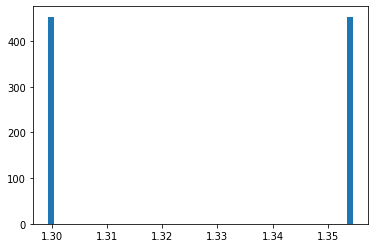

In [9]:
histogram_for_exp(Sst_ecs, True, False, False)





In [ ]:
histogram_for_exp(Vip_ecs, True, False, False)

all Sst experiment containers: 76
total cells: 63251
cells: 1054
cells with sig. response to drifting gratings: 508
direction-selective cells: 86
0 OSI: -2.9721149558668745
1 OSI: 2.7807195094783763
2 OSI: 1.5203479682149952
3 OSI: 2.053658245314432
4 OSI: 3.727851595911844


2022-07-28 15:50:36,856 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583659440


5 OSI: 1.5664859941912452
